# Late Fusion: Video Modeling

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/video/'
output_path = '../out/video/'
# Global configuration path
glob_conf_path = '../../../config/global_config_paper.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Load and shuffle data

In [4]:
from sklearn.utils import shuffle

train_intensity_df = pd.read_csv(input_path + 'video_data_intensity_train.csv')
train_shuffled_df = shuffle(train_intensity_df, random_state=seed)
train_shuffled_df

,AU01_r_mean,AU01_r_stddevNorm,AU01_r_percentile20.0,AU01_r_percentile50.0,AU01_r_percentile80.0,AU01_r_iqr60_80-20,AU01_r_numPeaks,AU02_r_mean,AU02_r_stddevNorm,AU02_r_percentile20.0,...,AU45_r_stddevNorm,AU45_r_percentile20.0,AU45_r_percentile50.0,AU45_r_percentile80.0,AU45_r_iqr60_80-20,AU45_r_numPeaks,actor_id,file_id,target,group
315,0.021233,0.229774,0.0,0.009934,0.025959,0.025959,0.392857,0.052355,0.300955,0.0,...,0.304999,0.0,0.043796,0.065714,0.065714,0.354839,3,315,9,3
1116,0.039485,0.224748,0.0,0.009934,0.064898,0.064898,0.214286,0.061165,0.328884,0.0,...,0.516488,0.0,0.007299,0.057143,0.057143,0.096774,9,1117,15,4
986,0.019033,0.265832,0.0,0.000000,0.028217,0.028217,0.250000,0.049915,0.312803,0.0,...,0.360287,0.0,0.036496,0.053571,0.053571,0.258065,8,987,14,5
1066,0.136671,0.338577,0.0,0.006623,0.143905,0.143905,0.142857,0.088052,0.428498,0.0,...,0.539384,0.0,0.021898,0.062857,0.062857,0.161290,9,1067,9,4
323,0.017401,0.202495,0.0,0.009934,0.019752,0.019752,0.500000,0.032410,0.326468,0.0,...,0.384070,0.0,0.014599,0.054286,0.054286,0.354839,3,323,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.069223,0.248553,0.0,0.009934,0.104402,0.104402,0.178571,0.094007,0.345926,0.0,...,0.468963,0.0,0.007299,0.045714,0.045714,0.161290,2,141,3,1
1048,0.110931,0.292778,0.0,0.004967,0.158014,0.158014,0.107143,0.121789,0.438431,0.0,...,0.380418,0.0,0.000000,0.318571,0.318571,0.129032,9,1049,6,4
752,0.035854,0.240812,0.0,0.013245,0.057562,0.057562,0.357143,0.037980,0.259521,0.0,...,0.272443,0.0,0.051095,0.046429,0.046429,0.354839,6,753,17,2
543,0.138369,0.282866,0.0,0.019868,0.224605,0.224605,0.357143,0.143821,0.367985,0.0,...,0.355894,0.0,0.036496,0.102143,0.102143,0.483871,5,543,6,3


### Other functions

In [5]:
from sklearn.metrics import confusion_matrix
    
def plot_save_conf_matrix(X, y, cv, clf, title, file_name, report=False):
    
    # Initialize some variables to store results
    conf_mat_avg = np.zeros([18,18])
    n_groups = 0
    for train_idx, val_idx in cv:
        n_groups += 1
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)    
        y_pred = clf.predict(X_val)                       # Predict class
        conf_mat_tmp = confusion_matrix(y_val,            # Compute confusion matrix for this batch
                                        y_pred,
                                        normalize='true'
                                       )
        conf_mat_avg += conf_mat_tmp
    
    conf_mat_avg /= n_groups
    
    
    df_cm = pd.DataFrame(conf_mat_avg, list(emotion_eng_id_to_emotion_num.keys()), list(emotion_eng_id_to_emotion_num.keys()))
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')        

## Elastic Net SGD Classifier

In [6]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
n_iter_no_change_values = [20, 50, 100, 150]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
parameters              = {'penalty': ['elasticnet'],
                           'class_weight': ['balanced'],
                           'loss': ['log'],
                           'random_state': [seed],
                           'alpha': alpha_values,
                           'l1_ratio': l1_ratio_values,
                           'n_iter_no_change': n_iter_no_change_values,
                           'max_iter': [2500]
                          }

elasticnet = SGDClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = elasticnet, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_groups)+'_logocv_intensity_video.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_intensity_video.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_intensity_video.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 32.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 55.9min finished


SGDClassifier(alpha=0.005, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.049, learning_rate='optimal', loss='log',
              max_iter=2500, n_iter_no_change=20, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=27, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)


In [7]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_class_weight,param_l1_ratio,param_loss,param_max_iter,param_n_iter_no_change,...,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
400,0.734591,0.026207,0.246964,0.014006,0.005,balanced,0.049,log,2500,20,...,27,"{'alpha': 0.005, 'class_weight': 'balanced', '...",0.830584,0.793716,0.778377,0.812364,0.757911,0.794590,0.025379,1
403,3.704671,0.045199,0.237698,0.005756,0.005,balanced,0.049,log,2500,150,...,27,"{'alpha': 0.005, 'class_weight': 'balanced', '...",0.830299,0.793962,0.778675,0.812390,0.757457,0.794557,0.025395,2
401,1.431749,0.046449,0.243053,0.013215,0.005,balanced,0.049,log,2500,50,...,27,"{'alpha': 0.005, 'class_weight': 'balanced', '...",0.830740,0.793288,0.779015,0.812416,0.757314,0.794554,0.025528,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.8685544925317211
AUC_std (train): 0.0046905200607915394
AUC_avg (validation): 0.7945902396407184
AUC_std (validation): 0.02537907557843901


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


UAR_avg (train): 0.39938488958442014
UAR_std (train): 0.016455992095712618
UAR_avg (validation): 0.2302469135802469
UAR_std (validation): 0.044752022124424355


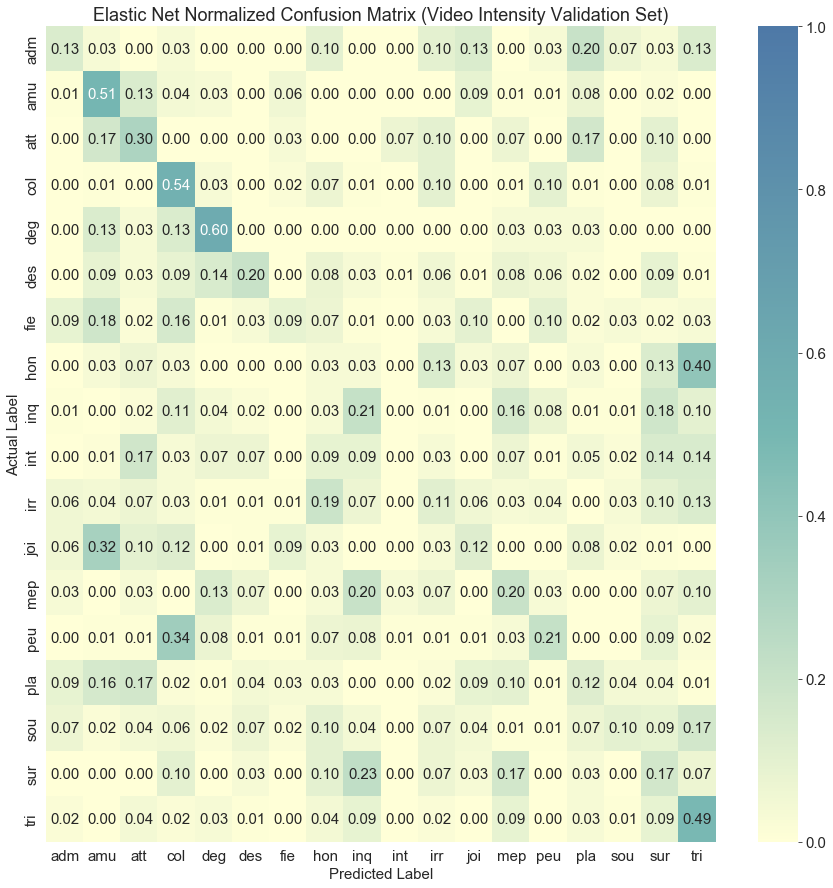

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_elastic_net_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = SGDClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Elastic Net Normalized Confusion Matrix (Video Intensity Validation Set)',
                      file_name = 'conf_mat_elastic_net_intensity_video.svg'
                     )

## kNN Classifier

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group


# Define parameters to evaluate
n_neigh_values   = np.arange(1, 905, 5).tolist()
leaf_size_values = [10, 20, 30]
algorithm_values = ['ball_tree','brute', 'kd_tree']
parameters      = {'n_neighbors': n_neigh_values,
                   'leaf_size': leaf_size_values,
                   'weights': ['uniform'],
                   'algorithm': algorithm_values,
                   'metric': ['manhattan'],
                   'n_jobs': [-1]
                  }

knn = KNeighborsClassifier()
logo = LeaveOneGroupOut()

clf = GridSearchCV(estimator  = knn, 
                   param_grid = parameters,
                   scoring    = 'roc_auc_ovo_weighted',
                   cv         = logo.split(X=X,groups=groups),
                   verbose    = 1,
                   n_jobs     = -1,
                  )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_groups)+'_logocv_intensity_video.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_knn_intensity_video.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_intensity_video.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 1629 candidates, totalling 8145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 13.8min


KNeighborsClassifier(algorithm='ball_tree', leaf_size=10, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=196, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Done 8145 out of 8145 | elapsed: 15.6min finished


In [44]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_metric,param_n_jobs,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
401,0.010636,0.000277,0.386138,0.018220,ball_tree,30,manhattan,-1,196,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm...",0.823231,0.772214,0.744551,0.802819,0.746998,0.777963,0.030904,1
1487,0.009232,0.001938,0.385587,0.011122,kd_tree,30,manhattan,-1,196,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'met...",0.823231,0.772214,0.744551,0.802819,0.746998,0.777963,0.030904,1
39,0.013652,0.004975,0.406825,0.036053,ball_tree,10,manhattan,-1,196,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'm...",0.823231,0.772214,0.744551,0.802819,0.746998,0.777963,0.030904,1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.8216092739679988
AUC_std (train): 0.007395303696185863
AUC_avg (validation): 0.7779627500385186
AUC_std (validation): 0.030903996672987422


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


UAR_avg (train): 0.19913710659015824
UAR_std (train): 0.00905414033232093
UAR_avg (validation): 0.16913580246913582
UAR_std (validation): 0.015542812730881697


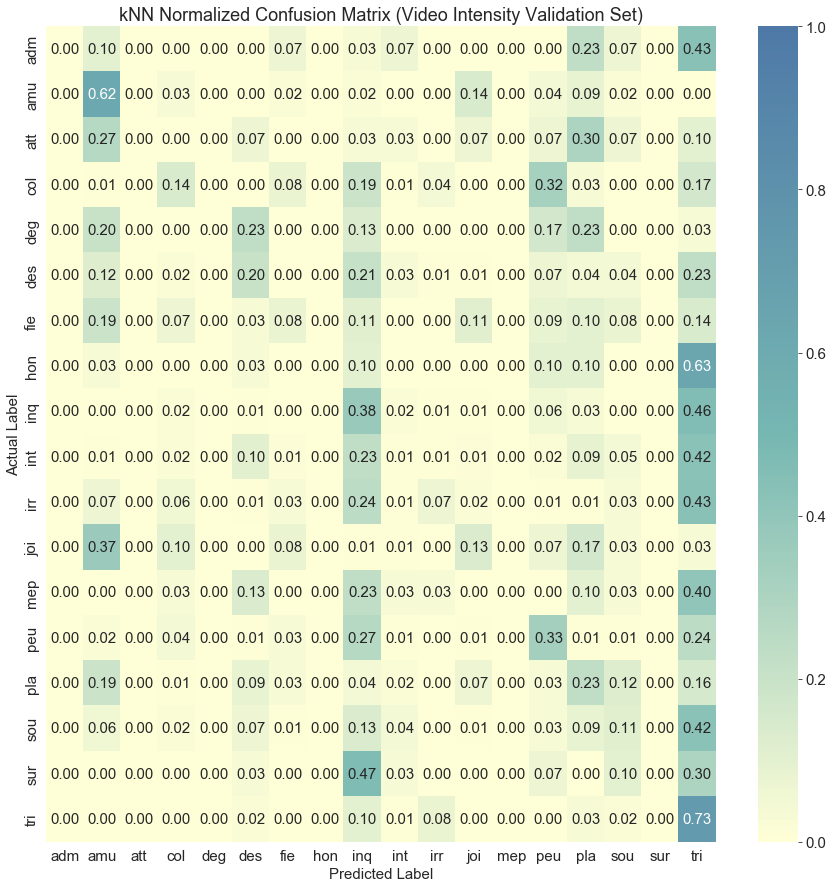

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_knn_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = KNeighborsClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'kNN Normalized Confusion Matrix (Video Intensity Validation Set)',
                      file_name = 'conf_mat_knn_intensity_video.svg'
                     )

## Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced'],
                   'random_state': [seed]
                  }

dt = DecisionTreeClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = dt, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         random_state        = seed,
                         n_iter              = 5000,
                         n_jobs              = -1
                         )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_groups)+'_logocv_intensity_video.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_tree_intensity_video.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_intensity_video.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=25, max_features=119,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=0.1,
                       min_samples_split=0.2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=27,
                       splitter='random')


In [18]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_splitter,param_random_state,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,...,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1236,0.009339,0.000300,0.274430,0.009200,random,27,0.2,0.1,119,25,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.710817,0.725613,0.660596,0.720167,0.677190,0.698877,0.025481,1
3496,0.009567,0.000508,0.273955,0.007969,random,27,0.2,0.1,119,10,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.710817,0.725613,0.660596,0.720167,0.677190,0.698877,0.025481,1
1299,0.009112,0.000227,0.279039,0.007333,random,27,0.2,0.1,119,50,...,balanced,"{'splitter': 'random', 'random_state': 27, 'mi...",0.721198,0.725957,0.660596,0.697686,0.650891,0.691266,0.030697,3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


AUC_avg (train): 0.7448707986106247
AUC_std (train): 0.007041378836727833
AUC_avg (validation): 0.6988766409010462
AUC_std (validation): 0.025480951378085877
UAR_avg (train): 0.19089506172839504
UAR_std (train): 0.014974703050257034
UAR_avg (validation): 0.15925925925925924
UAR_std (validation): 0.032698574415182785


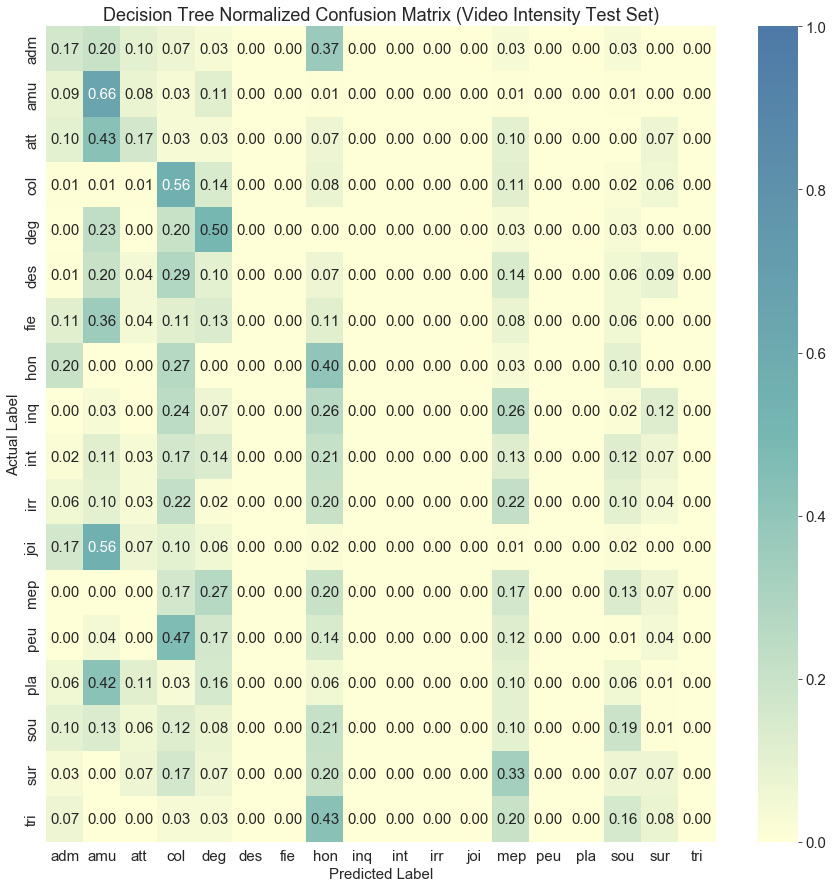

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_tree_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = DecisionTreeClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Decision Tree Normalized Confusion Matrix (Video Intensity Test Set)',
                      file_name = 'conf_mat_tree_intensity_video.svg'
                     )

## Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group
n_groups = len(groups.unique())


# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'random_state': [seed],
                   'class_weight': class_weight_values,
                   'n_jobs': [-1]
                  }

rf = RandomForestClassifier()
logo = LeaveOneGroupOut()

# Reduce the number of possible combinations by randomly resampling to 5000 combinations
clf = RandomizedSearchCV(estimator           = rf, 
                         param_distributions = parameters,
                         scoring             = 'roc_auc_ovo_weighted',
                         cv                  = logo.split(X=X,groups=groups),
                         verbose             = 1,
                         n_iter              = 5000,
                         random_state        = seed,
                         n_jobs              = -1
                        )
clf.fit(X,y)
print(clf.best_estimator_)

# Store results in a DataFrame and then save them as csv
results_df = pd.DataFrame(clf.cv_results_)
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_groups)+'_logocv_intensity_video.csv'), index=None, header=True)

# Save best parameters to disk
file_path = os.path.join(output_path,'best_params','best_params_rf_intensity_video.sav')
pickle.dump(clf.best_params_, open(file_path, 'wb'))

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_intensity_video.sav')
pickle.dump(clf.best_estimator_, open(file_path, 'wb'))

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 68.1min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 81.3min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 96.3min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 112.2min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 129.1min
[Parallel(n_jobs=-1)]: Done 11242 tasks     

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=110, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=495,
                       n_jobs=-1, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)


In [7]:
results_df.sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_jobs,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,...,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,3.776174,0.190488,0.760154,0.120320,27,-1,495,10,4,auto,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.830818,0.808149,0.770733,0.810250,0.770399,0.798070,0.023813,1
4608,3.622569,0.183137,0.737691,0.114865,27,-1,490,10,4,auto,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.831025,0.807527,0.771019,0.810198,0.770516,0.798057,0.023722,2
4249,3.798692,0.107166,0.687671,0.192137,27,-1,490,10,4,auto,...,True,"{'random_state': 27, 'n_jobs': -1, 'n_estimato...",0.831025,0.807527,0.771019,0.810198,0.770516,0.798057,0.023722,2


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


AUC_avg (train): 0.9992190385477816
AUC_std (train): 0.0001198257620601255
AUC_avg (validation): 0.7980697064910386
AUC_std (validation): 0.023813227007549204


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished


UAR_avg (train): 0.976536689271431
UAR_std (train): 0.003743260249245896
UAR_avg (validation): 0.23148148148148148
UAR_std (validation): 0.027048027531119304


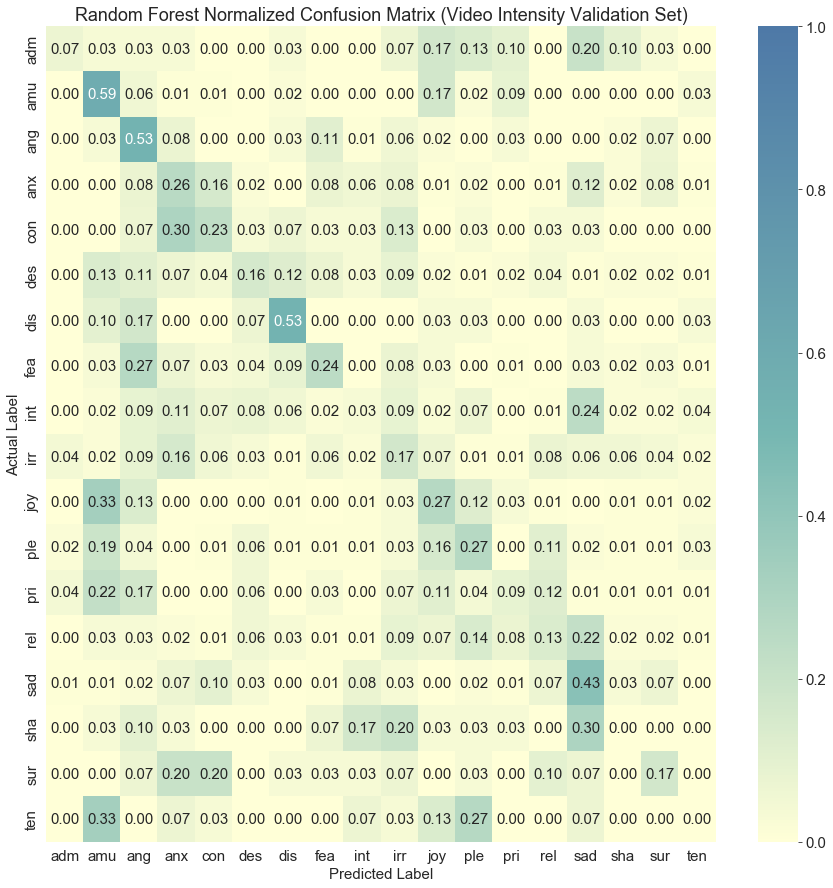

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# Obtain X, y, and groups from the training dataset
X = train_shuffled_df.drop(columns=['target','file_id','actor_id', 'group'])
y = train_shuffled_df.target
groups = train_shuffled_df.group

logo = LeaveOneGroupOut()


# Load best parameters
file_path = os.path.join(output_path,'best_params','best_params_rf_intensity_video.sav')
best_params = pickle.load(open(file_path, 'rb'))
                   
clf = RandomForestClassifier(**best_params)

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['roc_auc_ovo_weighted'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('AUC_avg (train):', np.mean(scores['train_roc_auc_ovo_weighted']))
print('AUC_std (train):', np.std(scores['train_roc_auc_ovo_weighted']))
print('AUC_avg (validation):', np.mean(scores['test_roc_auc_ovo_weighted']))
print('AUC_std (validation):', np.std(scores['test_roc_auc_ovo_weighted']))

scores = cross_validate(X=X, y=y,
                        estimator           = clf,
                        scoring             = ['recall_macro'],
                        cv                  = logo.split(X=X,groups=groups),
                        verbose             = 1,
                        n_jobs              = -1,
                        return_train_score  = True                        
                       )

print('UAR_avg (train):', np.mean(scores['train_recall_macro']))
print('UAR_std (train):', np.std(scores['train_recall_macro']))
print('UAR_avg (validation):', np.mean(scores['test_recall_macro']))
print('UAR_std (validation):', np.std(scores['test_recall_macro']))

# Confusion matrix
plot_save_conf_matrix(X         = X,
                      y         = y,
                      cv        = logo.split(X=X,groups=groups),
                      clf       = clf,
                      title     = 'Random Forest Normalized Confusion Matrix (Video Intensity Validation Set)',
                      file_name = 'conf_mat_rf_intensity_video.svg',
                      report    = True
                     )